In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
HEIGHT = 48
WIDTH = 24
DATASETNUMBER=3
EPOCH = 2001
total_height = 160
total_width=80

In [3]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
from __future__ import division, print_function, unicode_literals
import tensorflow as tf
from time import time
from keras.utils import np_utils#one hot
import os
from skimage import data
from skimage import transform
import skimage
import numpy as np

# Download the dataset


def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                  if os.path.isdir(os.path.join(data_directory,d))]
    labels=[]
    images=[]
    for d in directories:
        label_directory = os.path.join(data_directory,d)
        file_names = [os.path.join(label_directory,f)
                     for f in os.listdir(label_directory)
                     if f.endswith('.jpg')]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(str(d))
    return images, labels

Using TensorFlow backend.


In [4]:
size_of_name = str(HEIGHT)+'*'+str(WIDTH)


In [5]:
ROOT_PATH = '/home/tang/targa/exp4/Padding/splitTenDatasetPadding/'+str(DATASETNUMBER)+'splitDatasetPadding/'+size_of_name
train_data_directory = os.path.join(ROOT_PATH, "train/")
#validation_data_directory = os.path.join(ROOT_PATH, "16_8_1568_train") 16_8_4448_train  16_8_1248_train 

test_data_directory = os.path.join(ROOT_PATH, "test/")
validation_data_directory = os.path.join(ROOT_PATH,"validation/")

In [6]:
train_data_directory

'/home/tang/targa/exp4/Padding/splitTenDatasetPadding/3splitDatasetPadding/48*24/train/'

In [7]:
train_images,train_labels = load_data(train_data_directory)
test_images,test_labels = load_data(test_data_directory)
validation_images,validation_labels=load_data(validation_data_directory)

In [8]:
#encoding trY teY
from numpy import array
#from numpy import argmax
#from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example

#train_labels = np_utils.to_categorical(train_labels,num_classes = None)
#test_labels = np_utils.to_categorical(test_labels,num_classes = None)
trL,teL,valL=array(train_labels),array(test_labels),array(validation_labels)
label_encoder = LabelEncoder()

In [9]:
integer_encoded_trL = label_encoder.fit_transform(trL)
integer_encoded_teL = label_encoder.fit_transform(teL)
integer_encoded_valL = label_encoder.fit_transform(valL)

In [10]:
trainLabels = np_utils.to_categorical(integer_encoded_trL,num_classes = 32)
testLabels = np_utils.to_categorical(integer_encoded_teL,num_classes = 32)
validationLabels = np_utils.to_categorical(integer_encoded_valL,num_classes=32)

In [11]:
########convert rgb images into black and white
#convert images into size of vector
from skimage.color import rgb2gray

trainImages = rgb2gray(np.array(train_images))
testImages = rgb2gray(np.array(test_images))
validationImages = rgb2gray(np.array(validation_images))

train_flat_images = np.reshape(trainImages,(len(trainImages),total_height*total_width))
test_flat_images = np.reshape(testImages,(len(testImages),total_height*total_width))
validation_flat_images = np.reshape(validationImages,(len(validationImages),total_height*total_width))

In [12]:
train_flat_images[0].shape

(12800,)

In [13]:
print('train images shape:\t\t{}'.format(train_flat_images.shape))

print('test images shape:\t\t{}'.format(test_flat_images.shape))
print('validation images shape:\t\t{}'.format(validation_flat_images.shape))



train images shape:		(19675, 12800)
test images shape:		(2459, 12800)
validation images shape:		(2460, 12800)


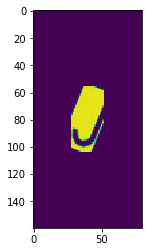

In [14]:
plt.imshow(trainImages[0])

In [15]:
batch_size = 100
n_batch = len(trainLabels)//batch_size
lr = tf.Variable(0.001,dtype = tf.float32)

In [16]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean',mean) # 平均值
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        tf.summary.scalar('stddev',stddev)
        tf.summary.scalar('max',tf.reduce_max(var))
        tf.summary.scalar('min',tf.reduce_min(var))
        tf.summary.histogram('histgram',var) # 直方图

In [17]:
#命名空间
with tf.name_scope('input'):
    #定义两个placeholder 
    #把批次的图片传进去，开始是100张一次的传送，直到最后
    x = tf.placeholder(tf.float32,[None,total_height*total_width],name='x-input')
    y = tf.placeholder(tf.float32,[None,32],name='y-input')
    #定义一个dropout的值
    keep_prob = tf.placeholder(tf.float32,name = 'non-dropout-rate')
with tf.name_scope('layer'):
    with tf.name_scope('W1'):
        #第一层
        W1 = tf.Variable(tf.truncated_normal([total_height*total_width,50],stddev=0.1),name='W1')#改成截断正太分布
    with tf.name_scope('b1'):
        
        b1 = tf.Variable(tf.zeros([50])+0.1,name = 'b1')
    with tf.name_scope('out1'):
        
        output1 = tf.matmul(x,W1) + b1
    with tf.name_scope('L1'):
        L1 = tf.nn.tanh(output1)
    with tf.name_scope('L1-drop'):
        #L1为第一层的输出，keep_prob为1的话就是不丢失，如果为0的话就是全丢，如果为0.5的话就是丢失50%的神经元
        L1_drop = tf.nn.dropout(L1,keep_prob)

    '''
    with tf.name_scope('W2'):
        #第二层
        W2 = tf.Variable(tf.truncated_normal([1000,2000],stddev=0.1),name='W2')
    with tf.name_scope('b2'):
        b2 = tf.Variable(tf.zeros([2000])+0.2,name='b2')
    with tf.name_scope('output2'):
        output2 = tf.matmul(L1_drop,W2)+b2
    with tf.name_scope('L2'):
        
        L2 = tf.nn.tanh(output2)
    with tf.name_scope('L2_drop'):
        #L1为第一层的输出，keep_prob为1的话就是不丢失，如果为0的话就是全丢，如果为0.5的话就是丢失50%的神经元
        L2_drop = tf.nn.dropout(L2,keep_prob)

    with tf.name_scope('W3'):
        #第三层
        W3 = tf.Variable(tf.truncated_normal([2000,1000],stddev=0.1),name='W3')
    with tf.name_scope('b3'):
        b3 = tf.Variable(tf.zeros([1000])+0.1,name='b3')
    with tf.name_scope('output3'):   
        output3 = tf.matmul(L2_drop,W3)+b3
    with tf.name_scope('L3'):
        L3 = tf.nn.tanh(output3)
    with tf.name_scope('L3-drop'):
        #L1为第一层的输出，keep_prob为1的话就是不丢失，如果为0的话就是全丢，如果为0.5的话就是丢失50%的神经元
        L3_drop = tf.nn.dropout(L3,keep_prob)
        '''
    with tf.name_scope('W4'):
    #第四层
        W4 = tf.Variable(tf.truncated_normal([50,32],stddev=0.1))
    with tf.name_scope('b4'):        
        b4 = tf.Variable(tf.zeros([32])+0.1)
    with tf.name_scope('output4'):
        output4 = tf.matmul(L1_drop,W4)+ b4
    with tf.name_scope('softmax'):
        #预测分类
        prediction = tf.nn.softmax(output4)
with tf.name_scope('loss'):
    #定义一个损失函数
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits = prediction))#联合交叉熵
    tf.summary.scalar('cross_entropy',loss)
    #loss = tf.reduce_mean(tf.square(y-prediction))
with tf.name_scope('train'):
    #定义一个方法来收敛神经网络，使用梯度下降法,学习率=0.1
    train_step = tf.train.AdamOptimizer(0.00001).minimize(loss)
    #train_step = tf.train.AdamOptimizer(0.1).minimize(loss)
#初始化
init = tf.global_variables_initializer()
with tf.name_scope('accuracy'):
    with tf.name_scope('correct-prediction'):
        #定义一个求准确率的方法
        #如果有两个相同的就会返回TRUE，不相同就返回false，然后就依次存入correct_prediction
        correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))#argmax返回一维张量中的最大值
    with tf.name_scope('accuracy'):    
        #求准确率
        #首先把bool值转化成32位的浮点数，然后求平均值
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        tf.summary.scalar('accuracy',accuracy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [18]:
merged = tf.summary.merge_all()

In [19]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [20]:
PAD_PATH = '/home/tang/targa/exp4/Padding/logs/'+str(DATASETNUMBER)+'splitDatasetPadding/'+size_of_name
train_log = os.path.join(PAD_PATH,'train')
test_log = os.path.join(PAD_PATH,'test')
table_log = os.path.join(PAD_PATH,'for_drawing')
if not os.path.exists(PAD_PATH):
    os.makedirs(PAD_PATH)

In [21]:
PAD_PATH

'/home/tang/targa/exp4/Padding/logs/3splitDatasetPadding/48*24'

In [22]:
with tf.Session() as sess:
    sess.run(init)
    #路径和文件名
    train_writer = tf.summary.FileWriter(train_log,sess.graph)
   
    test_writer = tf.summary.FileWriter(test_log,sess.graph)
    for epoch in range(EPOCH):#把所有的图片训练20次
        #一批一批的迭代图片，一次迭代100张，一共运行n_batch次
        for batch in range(n_batch):
            #每次传入一百张图片
            batch_xs,batch_ys = next_batch(batch_size,train_flat_images,trainLabels)
            sess.run(train_step,feed_dict={x:batch_xs,y:batch_ys,keep_prob:1.0})
        train_batch_xs,train_batch_ys = train_flat_images,trainLabels
        summary = sess.run(merged,feed_dict={x:train_batch_xs,y:train_batch_ys,keep_prob:1.0})           
        train_writer.add_summary(summary,epoch)
            
        test_batch_xs,test_batch_ys = test_flat_images,testLabels
        summary = sess.run(merged,feed_dict={x:test_batch_xs,y:test_batch_ys,keep_prob:1.0})
        test_writer.add_summary(summary,epoch)  
        
        test_acc = sess.run(accuracy,feed_dict={x:test_flat_images,y:testLabels,keep_prob:1.0})        
        train_acc = sess.run(accuracy,feed_dict={x:train_flat_images,y:trainLabels,keep_prob:1.0})
        test_loss = sess.run(loss,feed_dict={x:test_flat_images,y:testLabels,keep_prob:1.0}) 
        train_loss = sess.run(loss,feed_dict={x:train_flat_images,y:trainLabels,keep_prob:1.0})
        if epoch%200 == 0:
            
            print('epoch=' + str(epoch) + ',train accuracy='+ str(train_acc)+',test accuracy=' + str(test_acc)+',train loss='+str(train_loss)+',test loss='+str(test_loss))
        #write a file for this
        if not os.path.exists(table_log):
            os.makedirs(table_log)
        with open(table_log+'/'+'table.txt', 'a') as the_file:
            
            the_file.write(str(epoch)+' '+str(train_acc)+' '+str(test_acc)+' '+str(train_loss)+' '+str(test_loss)+'\n')

epoch=0,train accuracy=0.053468868,test accuracy=0.05164701,train loss=3.462163,test loss=3.4627266
epoch=200,train accuracy=0.7025667,test accuracy=0.69581133,train loss=2.8533566,test loss=2.860023
epoch=400,train accuracy=0.7325032,test accuracy=0.71370476,train loss=2.8108146,test loss=2.8253384
epoch=600,train accuracy=0.74373573,test accuracy=0.7226515,train loss=2.7926185,test loss=2.8117368
epoch=800,train accuracy=0.75161374,test accuracy=0.7275315,train loss=2.7812238,test loss=2.803342
epoch=1000,train accuracy=0.75583225,test accuracy=0.72875154,train loss=2.7734382,test loss=2.7981703
epoch=1200,train accuracy=0.76025414,test accuracy=0.7299715,train loss=2.7675369,test loss=2.79453
epoch=1400,train accuracy=0.76335454,test accuracy=0.7299715,train loss=2.7623928,test loss=2.7924905
epoch=1600,train accuracy=0.7664549,test accuracy=0.73241156,train loss=2.7583191,test loss=2.7899811
epoch=1800,train accuracy=0.7682846,test accuracy=0.73363155,train loss=2.7551322,test loss